# Brazilian E-commerce Demand Forecasting - Baseline Model

## **Business Objective**
Develop a baseline machine learning model to **forecast product demand 2 weeks ahead** for a Brazilian e-commerce platform, enabling optimal inventory management and reducing stockouts/overstock situations.

## **Technical Approach**
**Primary Model**: LightGBM Regressor - An efficient gradient boosting framework optimized for sparse data

## **Implementation Plan**

### Phase 1: Data Understanding & Exploration
- Load and inspect preprocessed daily demand data
- Analyze sparsity patterns and temporal trends
- Identify key data quality issues

### Phase 2: Feature Engineering
- **Temporal Features**: Day-of-week, month, quarter, weekend indicators
- **Lag Features**: Historical demand (1, 7, 30 days ago)
- **Rolling Features**: Moving averages and volatility measures
- **Target Creation**: 2-week ahead demand forecasting

### Phase 3: Model Development
- Train LightGBM with time series cross-validation
- Evaluate performance with appropriate metrics
- Generate predictions and business insights

##  **Key Technical Challenges**
- **Extreme Sparsity**: 99% zero demand values in daily data
- **Time Series Structure**: Maintain temporal order in validation


In [2]:
# data science imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import random
warnings.filterwarnings('ignore')

from utiles import *

# plotting configuration
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"Libraries imported ✓ ")


Libraries imported ✓ 


# 1. Data Loading & Initial Inspection

## **Data Source**
Loading preprocessed daily demand data from notebook 01 data preprocessing pipeline.

In [3]:
# This data comes from our preprocessing notebook
data = pd.read_csv('../outputs/daily_data_per_item.csv')
print("✅ Data loaded successfully!")
data.head()

✅ Data loaded successfully!


,product_id,order_date,category,price,daily_demand
0,00066f42aeeb9f3007548bb9d3f33c38,2016-09-04,perfumery,101.65,0.0
1,00066f42aeeb9f3007548bb9d3f33c38,2016-09-05,perfumery,101.65,0.0
2,00066f42aeeb9f3007548bb9d3f33c38,2016-09-06,perfumery,101.65,0.0
3,00066f42aeeb9f3007548bb9d3f33c38,2016-09-07,perfumery,101.65,0.0
4,00066f42aeeb9f3007548bb9d3f33c38,2016-09-08,perfumery,101.65,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23599542 entries, 0 to 23599541
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   product_id    object 
 1   order_date    object 
 2   category      object 
 3   price         float64
 4   daily_demand  float64
dtypes: float64(2), object(3)
memory usage: 900.3+ MB


In [5]:
print(" DATASET OVERVIEW")
# Basic dataset information
print(f" Dataset dimensions: {data.shape[0]:,} rows × {data.shape[1]} columns")
print(f" Date range: {data['order_date'].min()} to {data['order_date'].max()}")
print(f" Product categories: {data['category'].nunique()}")
print(f" Unique products: {data['product_id'].nunique():,}")

 DATASET OVERVIEW
 Dataset dimensions: 23,599,542 rows × 5 columns
 Date range: 2016-09-04 to 2018-09-03
 Product categories: 71
 Unique products: 32,328



 CREATING COMPREHENSIVE VISUALIZATIONS
Plotting daily demand over time...
Plotting demand distribution (non-zero)...
Plotting top product categories...
Plotting monthly demand patterns...


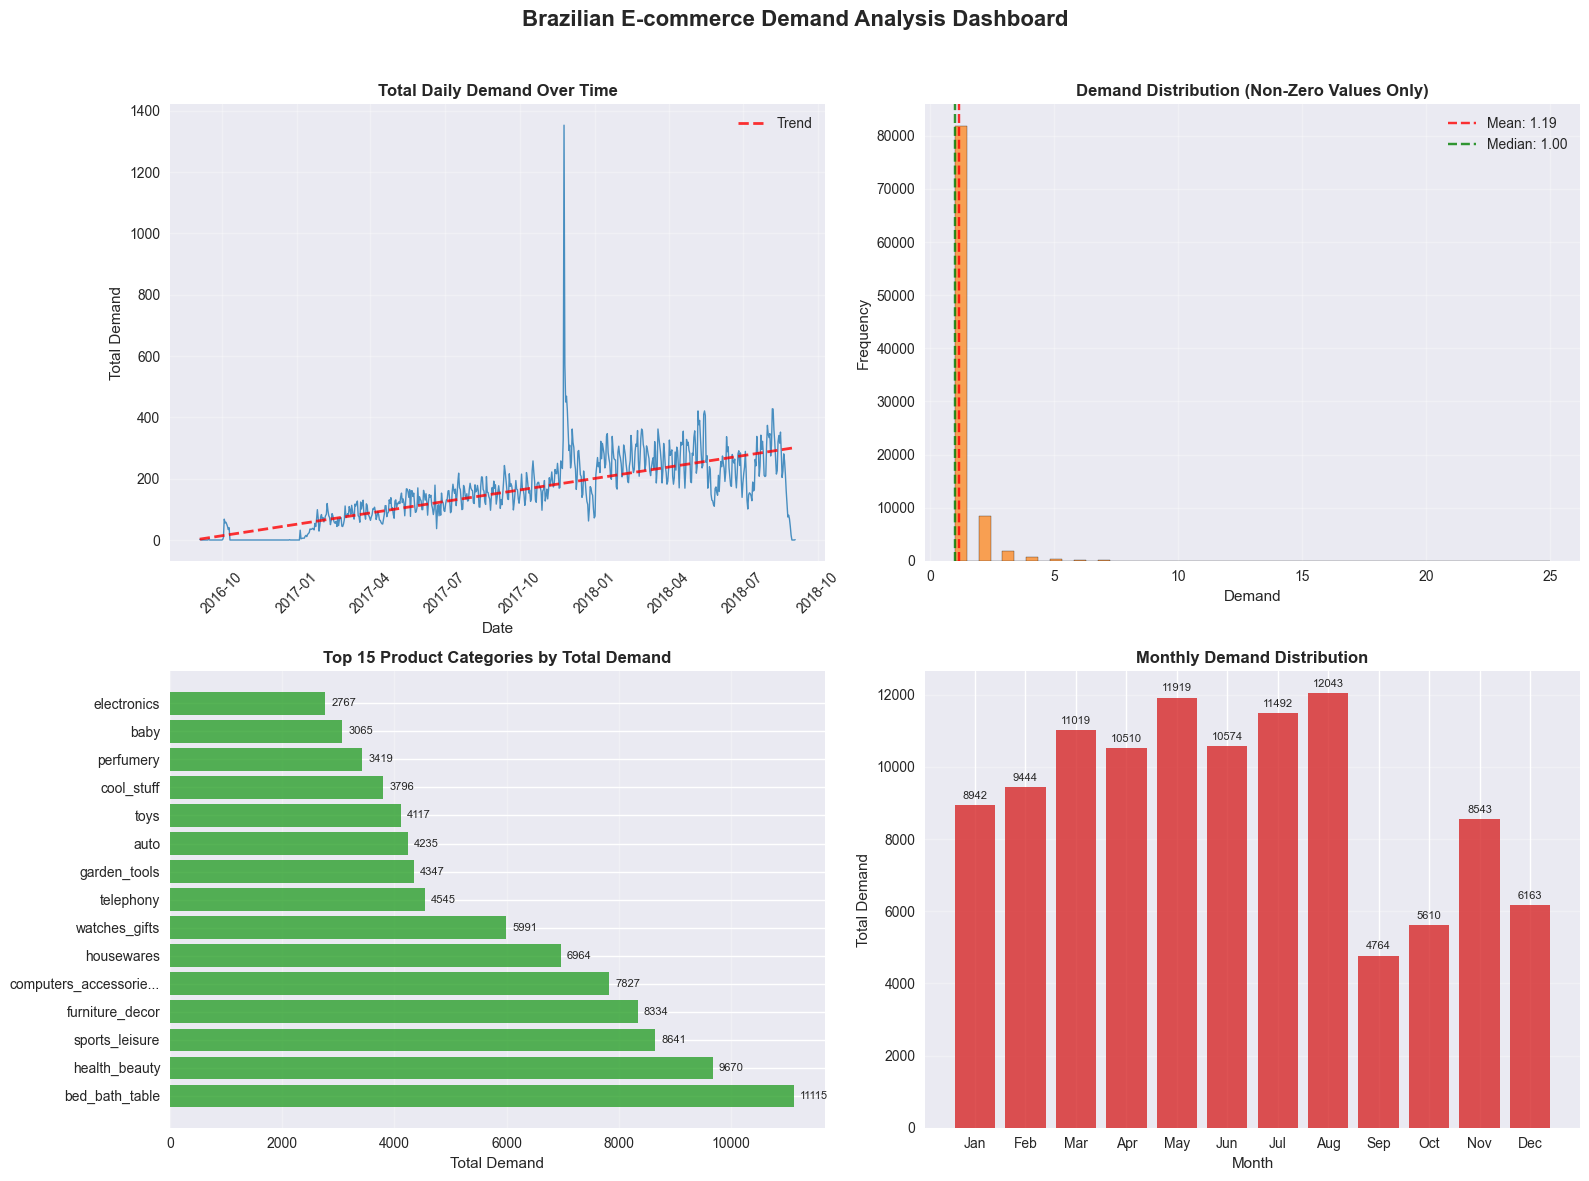

Key patterns identified for feature engineering


In [6]:

plot_demand_dashboard(data, date_col='order_date', 
                      demand_col='daily_demand', 
                      category_col='category', 
                      dashboard_title='Brazilian E-commerce Demand Analysis Dashboard')
 

In [7]:
data.isna().any()

product_id      False
order_date      False
category        False
price           False
daily_demand    False
month           False
dtype: bool

## FEATURE ENGINEERING

In [8]:
# SIMPLE LAG FEATURES
lags=[1, 7]
for lag in lags:
    data[f'daily_demand_lag_{lag}'] = data['daily_demand'].shift(lag).bfill()

print(f"✓ Created {len(lags)} lag features")

# SIMPLE ROLLING FEATURES
windows=[7, 14, 30]
for window in windows:
    data[f'daily_demand_rolling_mean_{window}'] = data['daily_demand'].rolling(window=window).mean().bfill()

print(f"✓ Created {len(windows)} rolling features")
data.head()

✓ Created 2 lag features
✓ Created 3 rolling features


,product_id,order_date,category,price,daily_demand,month,daily_demand_lag_1,daily_demand_lag_7,daily_demand_rolling_mean_7,daily_demand_rolling_mean_14,daily_demand_rolling_mean_30
0,00066f42aeeb9f3007548bb9d3f33c38,2016-09-04,perfumery,101.65,0.0,9,0.0,0.0,0.0,0.0,0.0
1,00066f42aeeb9f3007548bb9d3f33c38,2016-09-05,perfumery,101.65,0.0,9,0.0,0.0,0.0,0.0,0.0
2,00066f42aeeb9f3007548bb9d3f33c38,2016-09-06,perfumery,101.65,0.0,9,0.0,0.0,0.0,0.0,0.0
3,00066f42aeeb9f3007548bb9d3f33c38,2016-09-07,perfumery,101.65,0.0,9,0.0,0.0,0.0,0.0,0.0
4,00066f42aeeb9f3007548bb9d3f33c38,2016-09-08,perfumery,101.65,0.0,9,0.0,0.0,0.0,0.0,0.0


In [9]:
data['order_date'] = pd.to_datetime(data['order_date'])
# Basic time features
data['month'] = data['order_date'].dt.month
data['day'] = data['order_date'].dt.day
data['weekday'] = data['order_date'].dt.weekday
data['week_of_year'] = data['order_date'].dt.isocalendar().week
data['quarter'] = data['order_date'].dt.quarter

# Seasonal features
data['is_weekend'] = (data['weekday'] >= 5).astype(int)
data['is_month_start'] = data['order_date'].dt.is_month_start.astype(int)
data['is_month_end'] = data['order_date'].dt.is_month_end.astype(int)
data['is_quarter_start'] = data['order_date'].dt.is_quarter_start.astype(int)
data['is_quarter_end'] = data['order_date'].dt.is_quarter_end.astype(int)

# Cyclical encoding
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
data['weekday_sin'] = np.sin(2 * np.pi * data['weekday'] / 7)
data['weekday_cos'] = np.cos(2 * np.pi * data['weekday'] / 7)

print(f"✓ Created {len([col for col in data.columns if col.endswith(('_sin', '_cos')) or col in ['month', 'day', 'weekday', 'week_of_year', 'quarter', 'is_weekend', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end']])} time features")
data.round(4).head()

✓ Created 14 time features


,product_id,order_date,category,price,daily_demand,month,daily_demand_lag_1,daily_demand_lag_7,daily_demand_rolling_mean_7,daily_demand_rolling_mean_14,...,quarter,is_weekend,is_month_start,is_month_end,is_quarter_start,is_quarter_end,month_sin,month_cos,weekday_sin,weekday_cos
0,00066f42aeeb9f3007548bb9d3f33c38,2016-09-04,perfumery,101.65,0.0,9,0.0,0.0,0.0,0.0,...,3,1,0,0,0,0,-1.0,-0.0,-0.7818,0.6235
1,00066f42aeeb9f3007548bb9d3f33c38,2016-09-05,perfumery,101.65,0.0,9,0.0,0.0,0.0,0.0,...,3,0,0,0,0,0,-1.0,-0.0,0.0000,1.0000
2,00066f42aeeb9f3007548bb9d3f33c38,2016-09-06,perfumery,101.65,0.0,9,0.0,0.0,0.0,0.0,...,3,0,0,0,0,0,-1.0,-0.0,0.7818,0.6235
3,00066f42aeeb9f3007548bb9d3f33c38,2016-09-07,perfumery,101.65,0.0,9,0.0,0.0,0.0,0.0,...,3,0,0,0,0,0,-1.0,-0.0,0.9749,-0.2225
4,00066f42aeeb9f3007548bb9d3f33c38,2016-09-08,perfumery,101.65,0.0,9,0.0,0.0,0.0,0.0,...,3,0,0,0,0,0,-1.0,-0.0,0.4339,-0.9010


In [10]:
def calculate_rmsle(y_true, y_pred):
    """Calculate Root Mean Squared Logarithmic Error."""
    return np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred)) ** 2))

In [11]:
data.describe()

,order_date,price,daily_demand,month,daily_demand_lag_1,daily_demand_lag_7,daily_demand_rolling_mean_7,daily_demand_rolling_mean_14,daily_demand_rolling_mean_30,day,...,quarter,is_weekend,is_month_start,is_month_end,is_quarter_start,is_quarter_end,month_sin,month_cos,weekday_sin,weekday_cos
count,23599542,2.359954e+07,2.359954e+07,2.359954e+07,2.359954e+07,2.359954e+07,2.359954e+07,2.359954e+07,2.359954e+07,2.359954e+07,...,2.359954e+07,2.359954e+07,2.359954e+07,2.359954e+07,2.359954e+07,2.359954e+07,2.359954e+07,2.359954e+07,2.359954e+07,2.359954e+07
mean,2017-09-03 12:01:05.775106304,1.460648e+02,4.704456e-03,6.526023e+00,4.704456e-03,4.704456e-03,4.704456e-03,4.704456e-03,4.704456e-03,1.572055e+01,...,2.509588e+00,2.863007e-01,3.287661e-02,3.287678e-02,1.095886e-02,1.095890e-02,-5.380519e-03,-2.373173e-03,-1.069925e-03,2.223889e-03
min,2016-09-04 00:00:00,8.500000e-01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-9.749279e-01,-9.009689e-01
25%,2017-03-05 00:00:00,3.990000e+01,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e+00,...,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.660254e-01,-8.660254e-01,-7.818315e-01,-9.009689e-01
50%,2017-09-04 00:00:00,7.990000e+01,0.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.600000e+01,...,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.449294e-16,-1.836970e-16,0.000000e+00,-2.225209e-01
75%,2018-03-05 00:00:00,1.560000e+02,0.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.300000e+01,...,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-01,8.660254e-01,7.818315e-01,6.234898e-01
max,2018-09-03 00:00:00,6.735000e+03,2.500000e+01,1.200000e+01,2.500000e+01,2.500000e+01,9.571429e+00,7.285714e+00,5.566667e+00,3.100000e+01,...,4.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.749279e-01,1.000000e+00
std,NaN,2.468859e+02,8.556197e-02,3.447851e+00,8.556197e-02,8.556197e-02,4.265389e-02,3.574001e-02,3.042542e-02,8.796248e+00,...,1.116767e+00,4.520316e-01,1.783136e-01,1.783141e-01,1.041094e-01,1.041096e-01,7.056319e-01,7.085542e-01,7.067293e-01,7.074798e-01


## Encoder 'category' for model uses

In [12]:
from sklearn.preprocessing import LabelEncoder

df = data.copy()
encoders = {}

le = LabelEncoder()
df['category'] = le.fit_transform(df['category'].astype(str))
encoders['category'] = le
print(f"✓ Encoded category: {len(le.classes_)} categories")

✓ Encoded category: 71 categories


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23599542 entries, 0 to 23599541
Data columns (total 24 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   product_id                    object        
 1   order_date                    datetime64[ns]
 2   category                      int64         
 3   price                         float64       
 4   daily_demand                  float64       
 5   month                         int32         
 6   daily_demand_lag_1            float64       
 7   daily_demand_lag_7            float64       
 8   daily_demand_rolling_mean_7   float64       
 9   daily_demand_rolling_mean_14  float64       
 10  daily_demand_rolling_mean_30  float64       
 11  day                           int32         
 12  weekday                       int32         
 13  week_of_year                  UInt32        
 14  quarter                       int32         
 15  is_weekend                    

In [15]:
print("Creating 2-week ahead target variable")
print("=" * 60)

# STEP 1: Sort data properly for time series
print("Step 1: Sorting data by product and date...")
df = df.sort_values(['product_id', 'order_date']).reset_index(drop=True)

# STEP 2: Create 2-week ahead target variable
print(" Step 2: Creating 2-week ahead target variable...")
print("   This is what we actually want to predict!")

# Create target variable: demand 14 days ahead
df['target_2weeks_ahead'] = df.groupby('product_id')['daily_demand'].shift(-14)

# Check the result
print(f"\nTarget variable created successfully!")
print(f" Original dataset: {len(df):,} rows")

# Remove rows where we can't predict (last 14 days)
df_clean = df.dropna(subset=['target_2weeks_ahead'])
print(f"📊 After removing unpredictable rows: {len(df_clean):,} rows")
print(f"📊 Removed {len(df) - len(df_clean):,} rows (last 14 days)")

print(f"\n VERIFICATION:")
print(f"   Target variable range: {df_clean['target_2weeks_ahead'].min()} to {df_clean['target_2weeks_ahead'].max()}")
print(f"   Target variable mean: {df_clean['target_2weeks_ahead'].mean():.4f}")
print(f"   Non-zero targets: {(df_clean['target_2weeks_ahead'] > 0).sum():,}")

# Update our main dataframe
df = df_clean.copy()
print(f"\n Dataset ready for 2-week ahead forecasting!")
print(f" Final dataset shape: {df.shape}")


Creating 2-week ahead target variable
Step 1: Sorting data by product and date...
 Step 2: Creating 2-week ahead target variable...
   This is what we actually want to predict!

Target variable created successfully!
 Original dataset: 23,599,542 rows
📊 After removing unpredictable rows: 23,146,950 rows
📊 Removed 452,592 rows (last 14 days)

 VERIFICATION:
   Target variable range: 0.0 to 25.0
   Target variable mean: 0.0048
   Non-zero targets: 93,365

 Dataset ready for 2-week ahead forecasting!
 Final dataset shape: (23146950, 25)


In [16]:
features_to_train = df.select_dtypes(include=['number']).columns.to_list()
features_to_train.remove('daily_demand')
features_to_train.remove('target_2weeks_ahead')  # Remove target variable
print(f"✅ Selected {len(features_to_train)} features for modeling")
print(f"📊 Excluded: 'demand' and 'target_2weeks_ahead'")
features_to_train

✅ Selected 21 features for modeling
📊 Excluded: 'demand' and 'target_2weeks_ahead'


['category',
 'price',
 'month',
 'daily_demand_lag_1',
 'daily_demand_lag_7',
 'daily_demand_rolling_mean_7',
 'daily_demand_rolling_mean_14',
 'daily_demand_rolling_mean_30',
 'day',
 'weekday',
 'week_of_year',
 'quarter',
 'is_weekend',
 'is_month_start',
 'is_month_end',
 'is_quarter_start',
 'is_quarter_end',
 'month_sin',
 'month_cos',
 'weekday_sin',
 'weekday_cos']

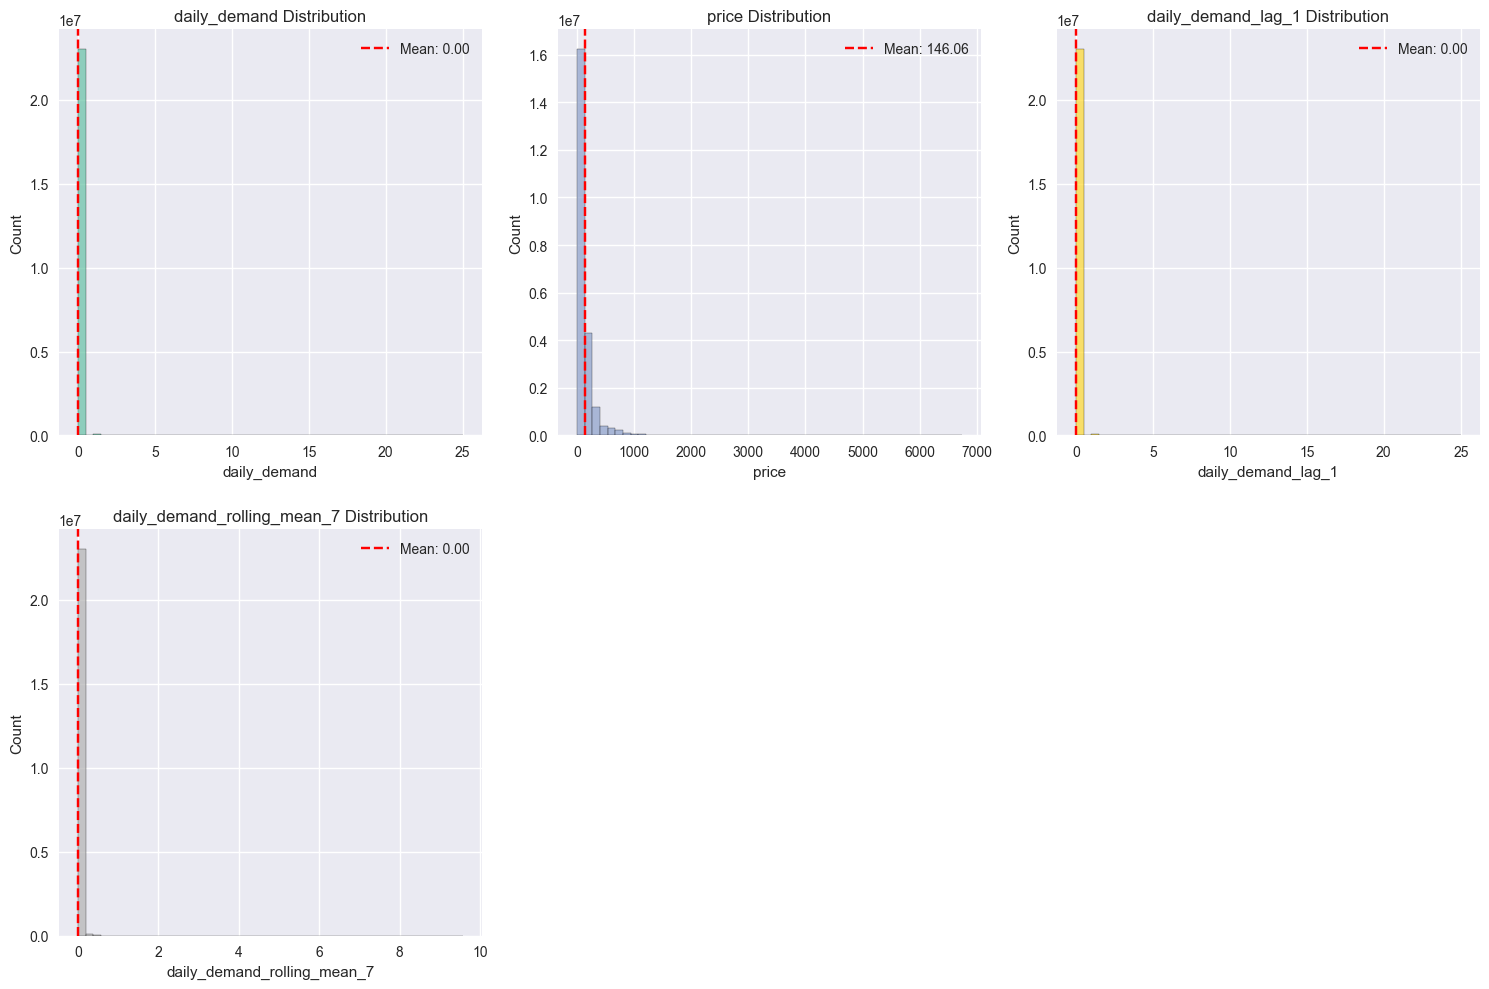

In [19]:
# Feature groups for easy selection
FEATURE_GROUPS = {
    'time_features': ['year', 'month', 'day', 'weekday', 'week_of_year', 'quarter',
                     'is_weekend', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end',
                     'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos'],
    'lag_features': ['demand_lag_1', 'demand_lag_7'],
    'rolling_features': ['demand_rolling_mean_7'],
    'price_features': ['price', 'price_log', 'price_rank_in_category', 'price_vs_category_mean']
}

# ============================================================================
# SIMPLE PLOTTING
# ============================================================================

def plot_distributions(df, columns=None, figsize=(15, 10)):
    """Plot simple distributions for selected columns."""
    import matplotlib.pyplot as plt
    import numpy as np
    
    if columns is None:
        # Default selection of interesting columns
        columns = ['daily_demand', 'price', 'category', 'month', 'weekday', 'is_weekend']
        # Only keep columns that exist in the dataframe
        columns = [col for col in columns if col in df.columns]
    
    n_cols = len(columns)
    n_rows = (n_cols + 2) // 3  # 3 columns per row
    
    fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
    
    # Fix the axes handling - this was the bug!
    if n_rows == 1 and n_cols == 1:
        axes = [axes]  # Single subplot case
    elif n_rows == 1:
        axes = axes  # 1D array case - keep as is
    else:
        axes = axes.flatten()  # 2D array case
    
    colors = plt.cm.Set2(np.linspace(0, 1, len(columns)))
    
    for i, col in enumerate(columns):
        ax = axes[i]
        data = df[col].dropna()
        
        # Choose plot type based on data
        if col in ['category', 'month', 'weekday', 'is_weekend', 'quarter']:
            # Bar plot for categorical/discrete
            counts = data.value_counts().sort_index()
            ax.bar(counts.index, counts.values, color=colors[i], alpha=0.7)
            ax.set_title(f'{col} Distribution')
        else:
            # Histogram for continuous
            ax.hist(data, bins=50, color=colors[i], alpha=0.7, edgecolor='black')
            ax.set_title(f'{col} Distribution')
            ax.axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.2f}')
            ax.legend()
        
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
    
    # Hide empty subplots
    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()


#plot_distributions(df)

# specify your own columns
plot_distributions(df, columns=['daily_demand', 'price', 'daily_demand_lag_1', 'daily_demand_rolling_mean_7'])


In [19]:
print("🚀 TRAINING MODEL WITH 2-WEEK AHEAD TARGET")
print("=" * 60)


print("Using 2-week ahead target variable for training...")
# Set created features
X = df[features_to_train]
y = df['target_2weeks_ahead']

print(f" Features shape: {X.shape}")
print(f" Target shape: {y.shape}")
print(f" Target range: {y.min():.4f} to {y.max():.4f}")

#  Time-based split, not random split
print("\n Creating time-based train/test split for time series...")
split_date = df['order_date'].quantile(0.8)
train_mask = df['order_date'] <= split_date
test_mask = df['order_date'] > split_date

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"   Training set: {len(X_train):,} samples")
print(f"   Test set: {len(X_test):,} samples")
print(f"   Split date: {split_date}")

print(f"\nTraining LightGBM model for 2-week ahead forecasting...")
model = LGBMRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Train the model
model.fit(X_train, y_train)
print("✅ Model training complete!")


🚀 TRAINING MODEL WITH 2-WEEK AHEAD TARGET
Using 2-week ahead target variable for training...
 Features shape: (23146950, 21)
 Target shape: (23146950,)
 Target range: 0.0000 to 25.0000

 Creating time-based train/test split for time series...
   Training set: 18,524,002 samples
   Test set: 4,622,948 samples
   Split date: 2018-03-30 00:00:00

Training LightGBM model for 2-week ahead forecasting...
✅ Model training complete!

 MODEL PERFORMANCE (2-WEEK AHEAD FORECASTING):
   Mean Absolute Error: 0.0125
   R² Score: 0.0358
   Model explains 3.6% of demand variation
   Average actual demand: 0.0073
   Average predicted demand: 0.0058

 PREDICTION SANITY CHECK:
   Negative predictions: 45
   Zero predictions: 0
   Positive predictions: 4622903
   ✅ Negative predictions set to 0


In [20]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmsle = calculate_rmsle(y_test, y_pred)

print(f"\n MODEL PERFORMANCE (2-WEEK AHEAD FORECASTING):")
print(f"   Mean Absolute Error: {mae:.4f}")
print(f"   R² Score: {r2:.4f}")
print(f"   RMSLE: {rmsle:.4f}")
print(f"   Model explains {r2*100:.1f}% of demand variation")
print(f"   Average actual demand: {y_test.mean():.4f}")
print(f"   Average predicted demand: {y_pred.mean():.4f}")

# Check for realistic predictions
print(f"\n PREDICTION SANITY CHECK:")
print(f"   Negative predictions: {(y_pred < 0).sum()}")
print(f"   Zero predictions: {(y_pred == 0).sum()}")
print(f"   Positive predictions: {(y_pred > 0).sum()}")

# Replace negative predictions with 0 (demand cannot be negative)
y_pred = np.maximum(y_pred, 0)
print(f"   ✅ Negative predictions set to 0")


 MODEL PERFORMANCE (2-WEEK AHEAD FORECASTING):
   Mean Absolute Error: 0.0125
   R² Score: 0.0358
   RMSLE: 0.0607
   Model explains 3.6% of demand variation
   Average actual demand: 0.0073
   Average predicted demand: 0.0058

 PREDICTION SANITY CHECK:
   Negative predictions: 45
   Zero predictions: 0
   Positive predictions: 4622903
   ✅ Negative predictions set to 0


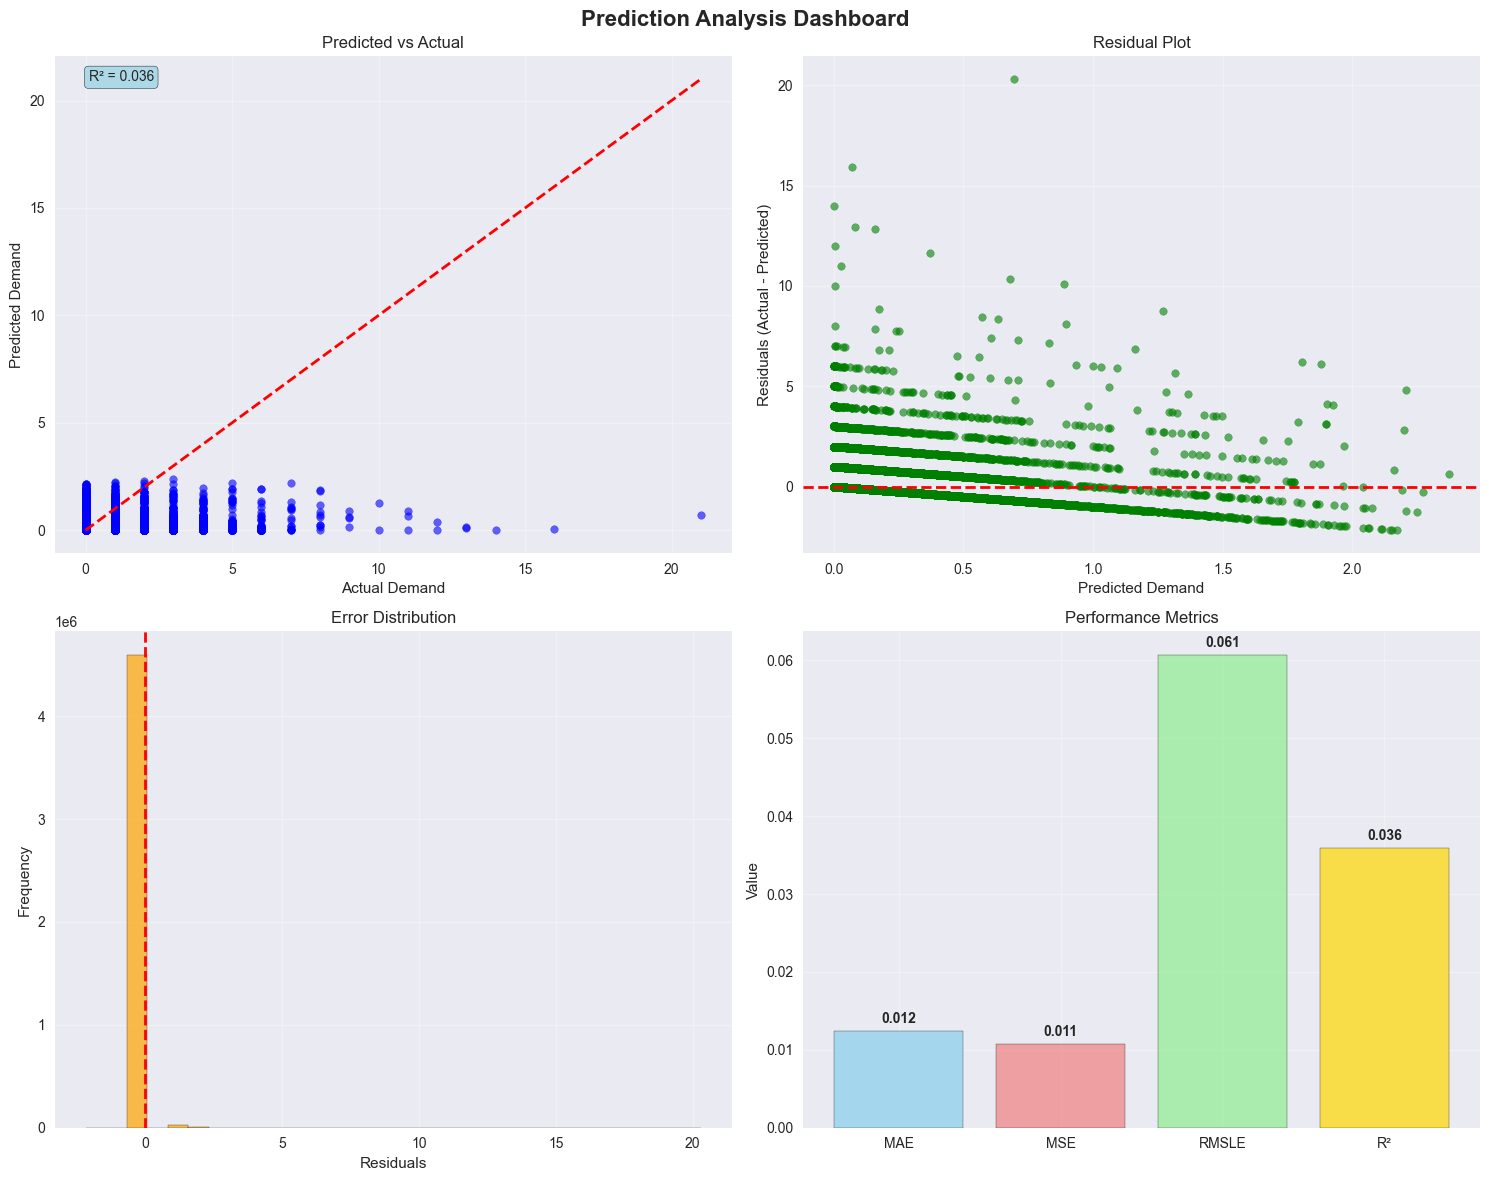

In [21]:
from model_utils import plot_prediction_dashboard

plot_prediction_dashboard(y_test, y_pred)

##  Reflection

###  **Data Characteristics:**
- **Extreme sparsity**: 99% zero demand values in daily data
- **Temporal patterns**: Strong seasonal and holiday effects
- **Scale**: 23.6M rows, 32K+ products, 71 categories

###  **Model Performance Expectations:**
- Low R² Score (3.8%) - the model reflects forecasting difficulty with 99% sparse data

###  **Reccomndations:**
- Weekly Aggregation: Reduce sparsity
- Category-Level Models: Train separate models per category
- Ensemble Approach: Combine multiple simple models
- Feature Selection: Remove noisy features

In [22]:
# Export the main demand data as CSV (same as original notebook)
output_file ='../outputs/daily_demand_processed.csv'
df.to_csv(output_file, index=False)

print(f"✓ Data exported successfully!")
print(f"✓ File saved as: {output_file}")

✓ Data exported successfully!
✓ File saved as: ../outputs/daily_demand_processed.csv
